In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA

from time import perf_counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install gdown
!gdown --id 1pRVk_O_hy9LVuHNWbDrdagZlI8WgRUNr -O dataset.csv
data = pd.read_csv('dataset.csv')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pRVk_O_hy9LVuHNWbDrdagZlI8WgRUNr
To: /content/dataset.csv
100% 1.44M/1.44M [00:00<00:00, 36.5MB/s]


In [3]:
print(data.shape)
print(data.dtypes)
print(data.info())

(7043, 38)
Customer ID                           object
Gender                                object
Age                                    int64
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download              float64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object

In [4]:
data = data.drop(['Customer ID', 'City', 'Zip Code', 'Churn Category', 'Churn Reason'], axis=1)

In [5]:
data.duplicated().sum()

0

In [6]:
df1 = data.select_dtypes(exclude='number')

In [7]:
df1.describe().T

,count,unique,top,freq
Gender,7043,2,Male,3555
Married,7043,2,No,3641
Offer,7043,6,None,3877
Phone Service,7043,2,Yes,6361
Multiple Lines,6361,2,No,3390
Internet Service,7043,2,Yes,5517
Internet Type,5517,3,Fiber Optic,3035
Online Security,5517,2,No,3498
Online Backup,5517,2,No,3088
Device Protection Plan,5517,2,No,3095


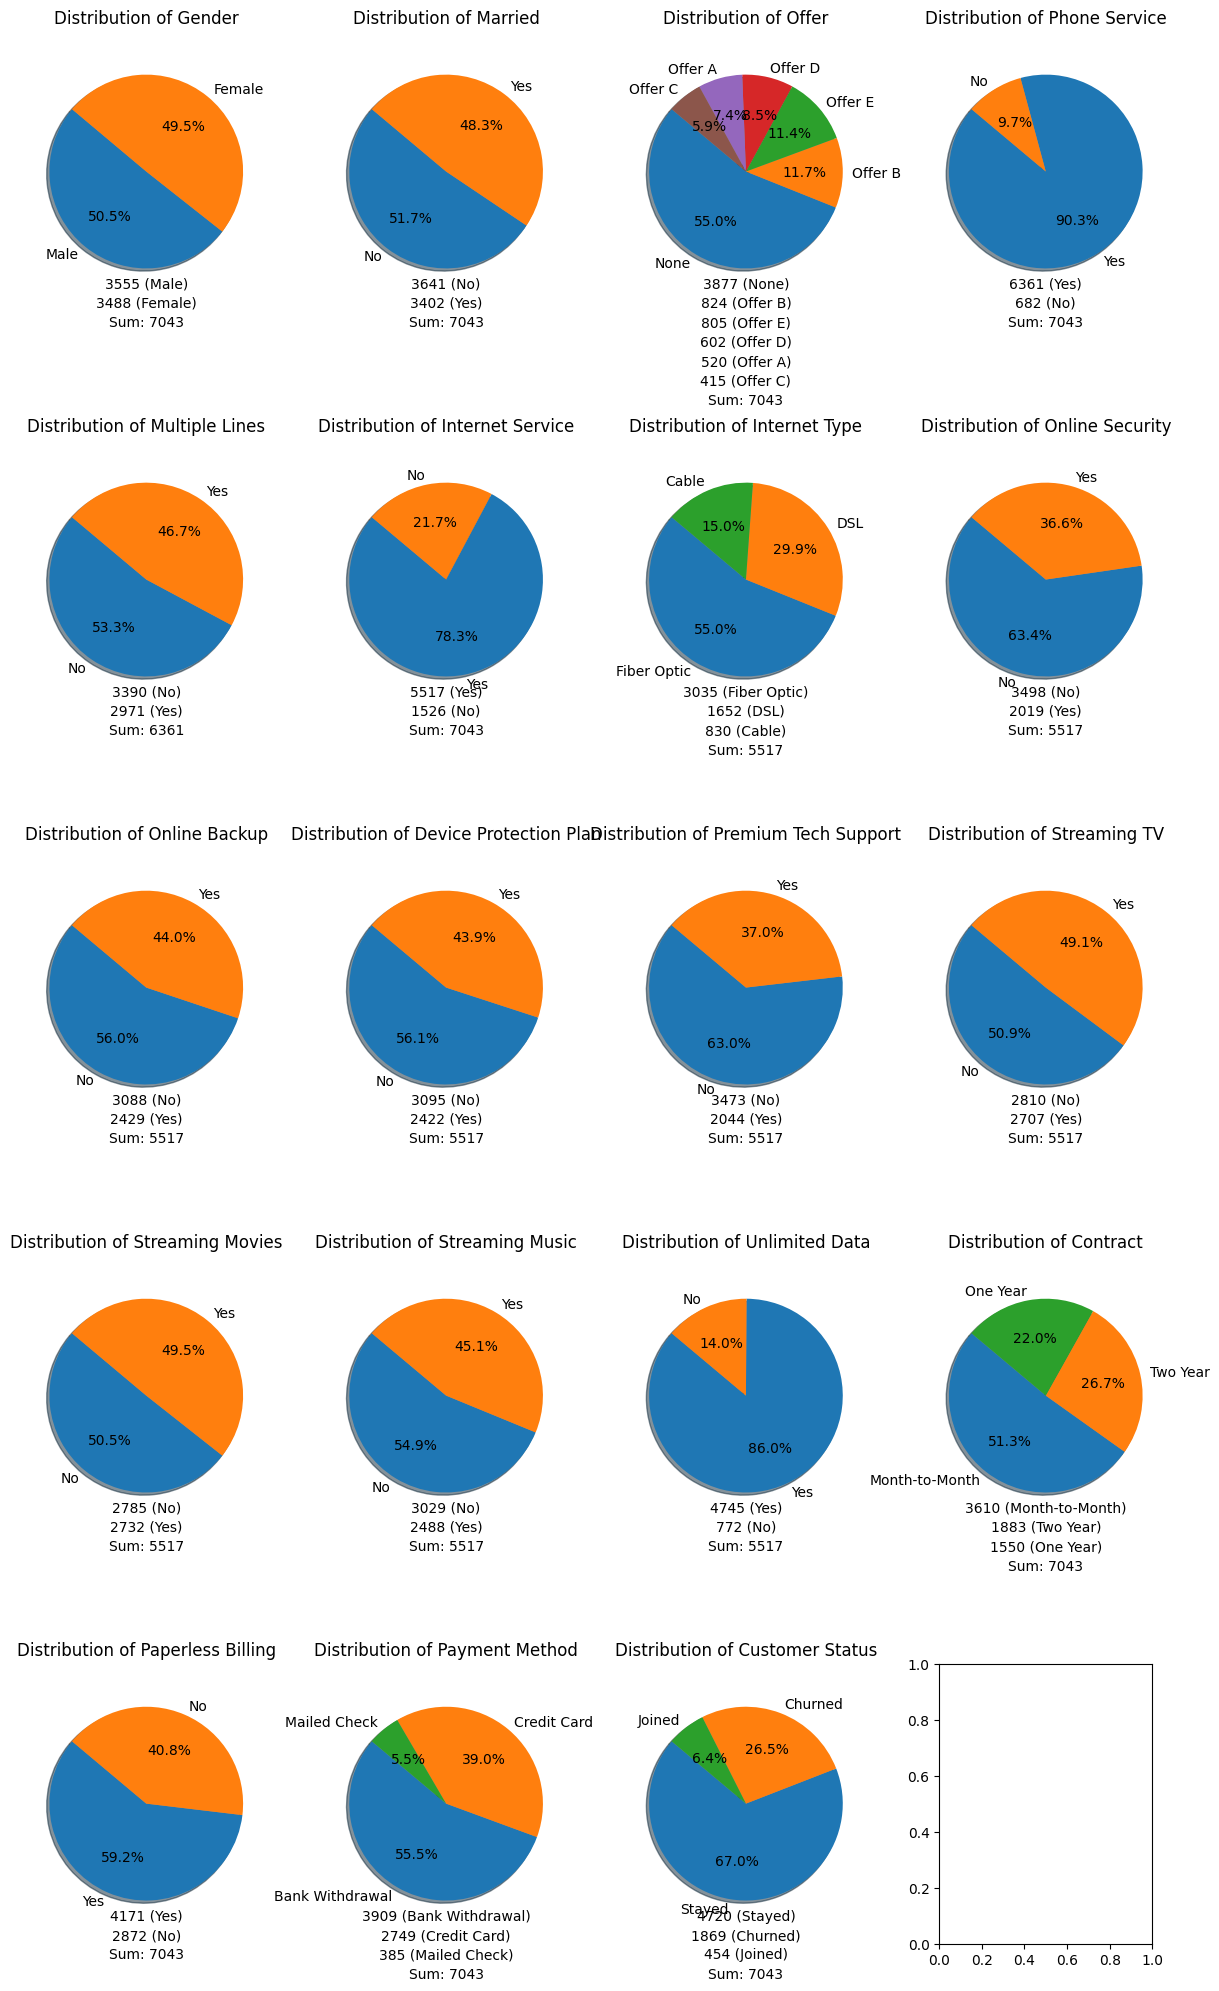

In [8]:
num_rows = 5
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

for i, column in enumerate(df1.columns):
    categories = df1[column].value_counts()

    ax = axes[i // num_cols, i % num_cols]

    ax.pie(categories, labels=categories.index, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')
    ax.set_title(f'Distribution of {column}')

    # Add text annotations for value count and sum
    total = categories.values.sum()
    sum_text = f'Sum: {total}'
    ax.text(0, -1.2 - len(categories)*0.2, sum_text, ha='center')

    for j, percentage in enumerate(categories):
        percent_text = f'{percentage} ({categories.index[j]})'
        ax.text(0, -1.2 - j*0.2, percent_text, ha='center')

plt.tight_layout()
plt.show()

null values in nominal features:
Gender                       0
Married                      0
Offer                        0
Phone Service                0
Multiple Lines             682
Internet Service             0
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
Contract                     0
Paperless Billing            0
Payment Method               0
Customer Status              0
dtype: int64


<Axes: >

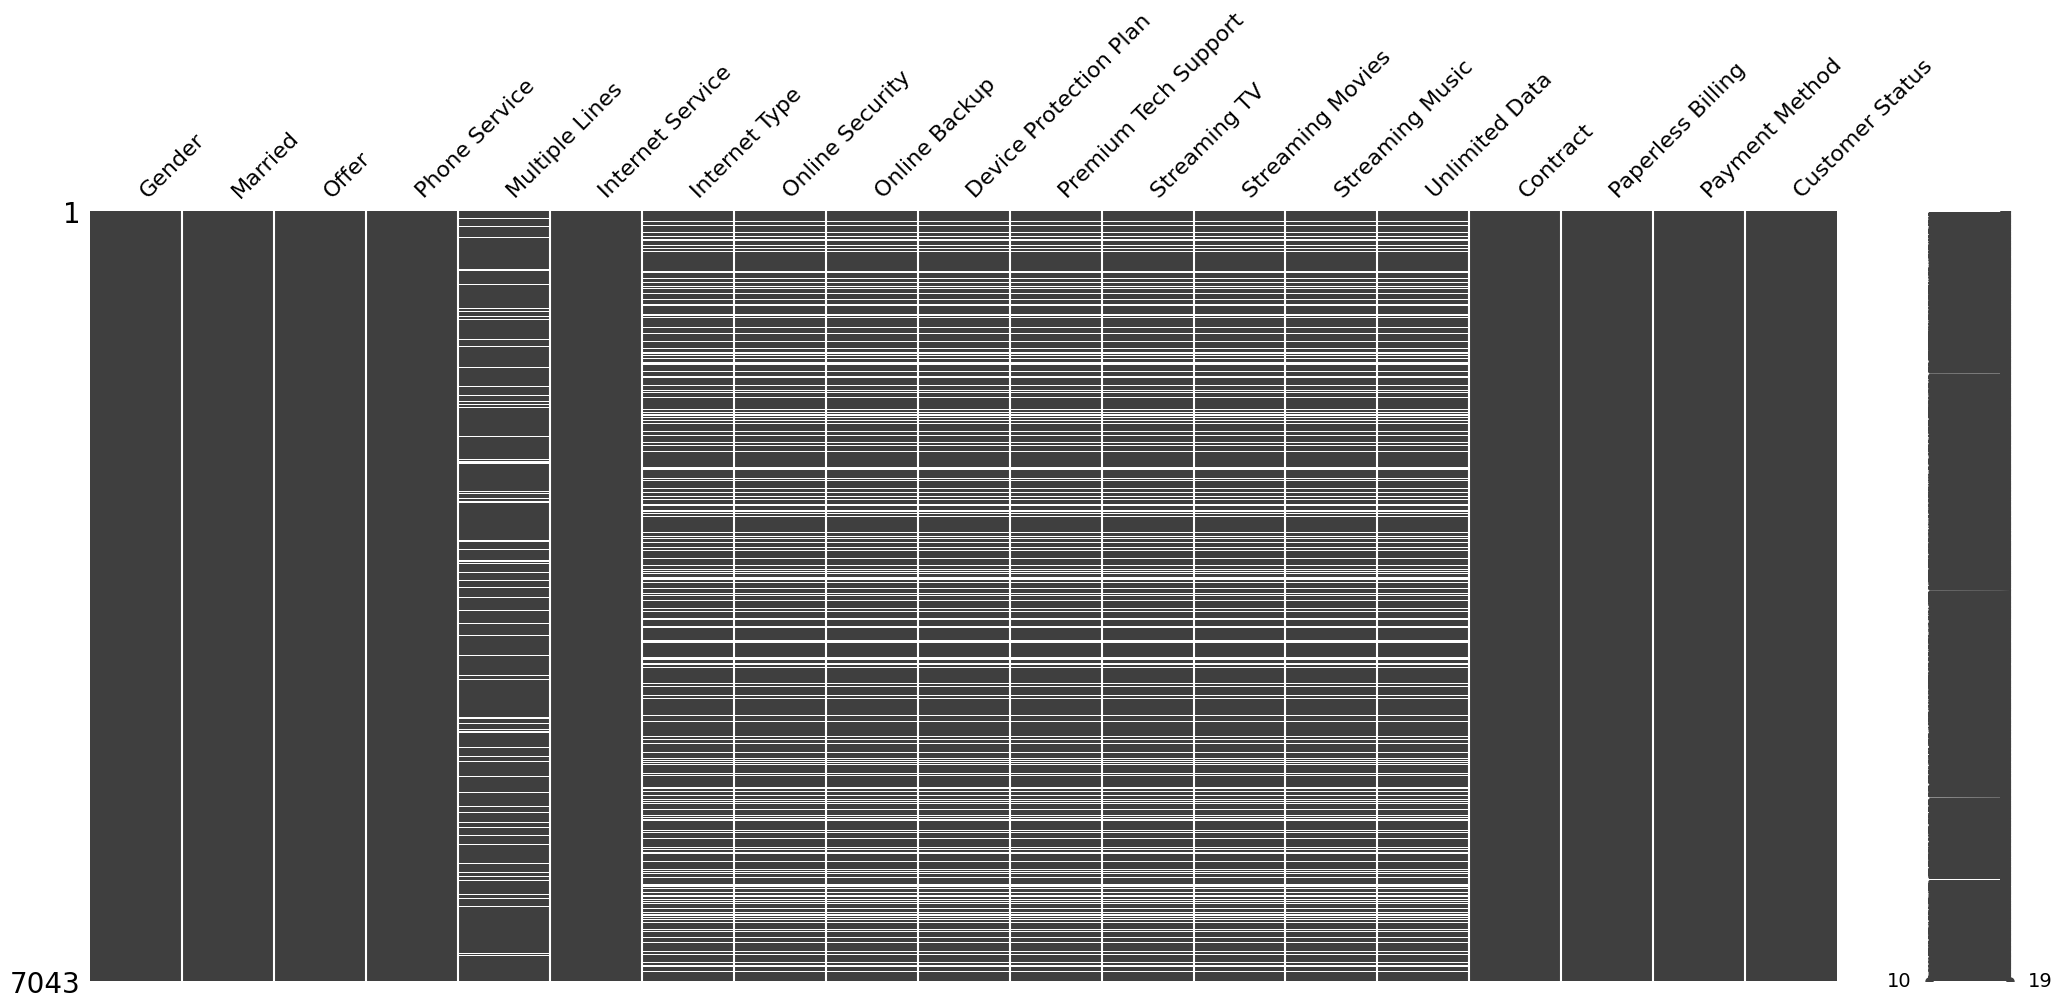

In [9]:
print(f"null values in nominal features:\n{df1.isna().sum()}")
msno.matrix(df1)

In [11]:
#filling null values
df1['Internet Type'] = df1['Internet Type'].apply(lambda x: 'None' if pd.isnull(x) else x)

column_name = ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
               'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data']
for column in column_name:
  df1[column] = df1[column].apply(lambda x: 'No' if pd.isnull(x) else x)

<Axes: >

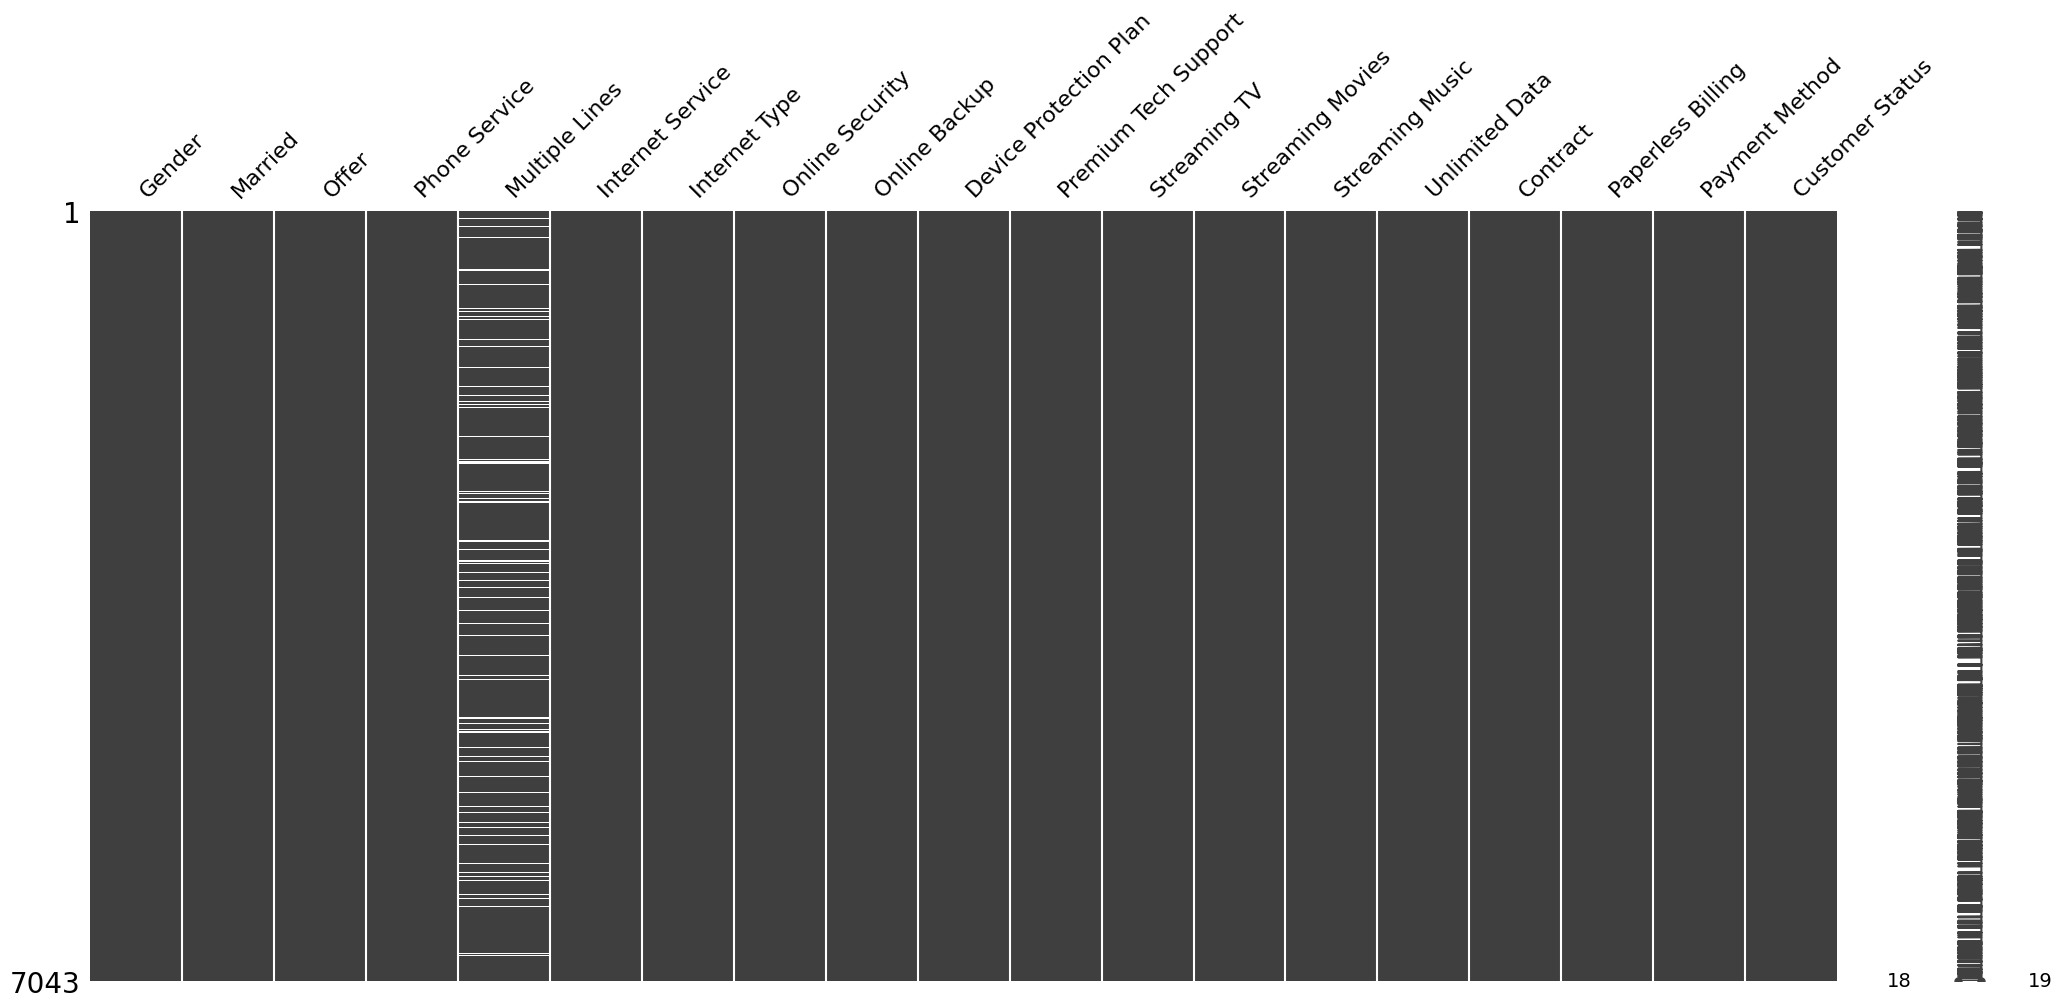

In [12]:
msno.matrix(df1)


In [13]:
# first step:
conversion_dict = {"Yes": 1, "No": 0}
df1['Multiple Lines'] = df1['Multiple Lines'].map(conversion_dict)

# second step: labeling the target by using LabelEncoder
label_encoder = LabelEncoder()
df1['Customer Status'] = label_encoder.fit_transform(df1['Customer Status'])

# third step: using pd.get_dummies for other features
df1 = pd.get_dummies(df1, drop_first=True)

In [14]:
# the KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(df1)
imputed_data = np.round(imputed_data)
# If we want to keep the DataFrame format:
df1_imputed = pd.DataFrame(data=imputed_data, columns=df1.columns)

0.0    3806
1.0    3237
Name: Multiple Lines, dtype: int64

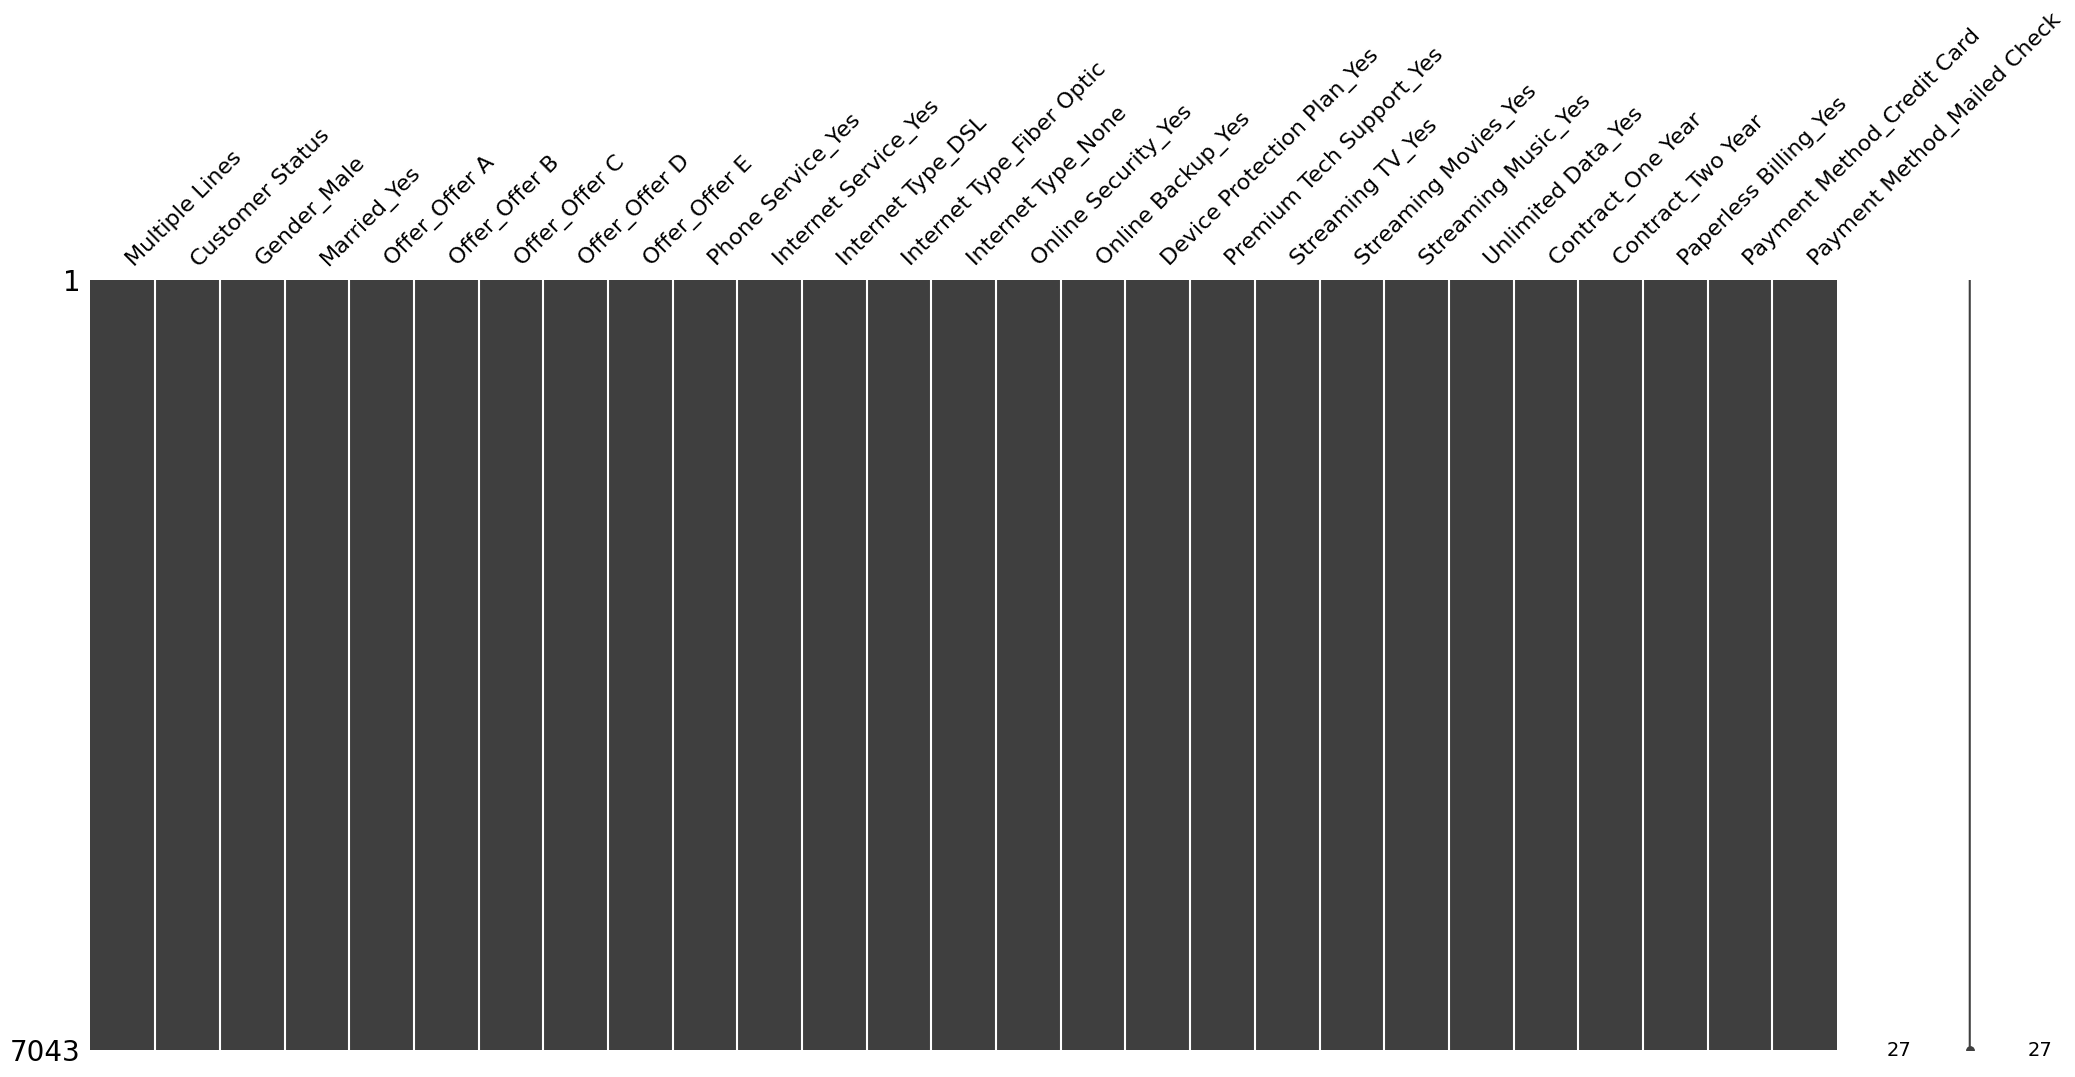

In [15]:
msno.matrix(df1_imputed)
df1_imputed['Multiple Lines'].value_counts()

In [16]:
df2 = data.select_dtypes(include='number')

In [17]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
Number of Dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
Latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
Longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
Number of Referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
Tenure in Months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
Avg Monthly Long Distance Charges,6361.0,25.420517,14.200374,1.010000,13.050000,25.690000,37.680000,49.990000
Avg Monthly GB Download,5517.0,26.189958,19.586585,2.000000,13.000000,21.000000,30.000000,85.000000
Monthly Charge,7043.0,63.596131,31.204743,-10.000000,30.400000,70.050000,89.750000,118.750000
Total Charges,7043.0,2280.381264,2266.220462,18.800000,400.150000,1394.550000,3786.600000,8684.800000


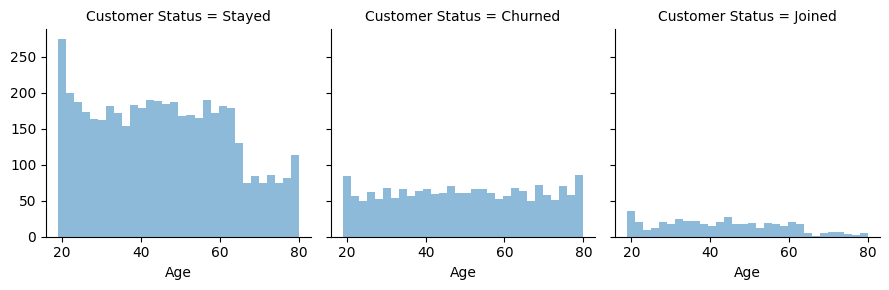

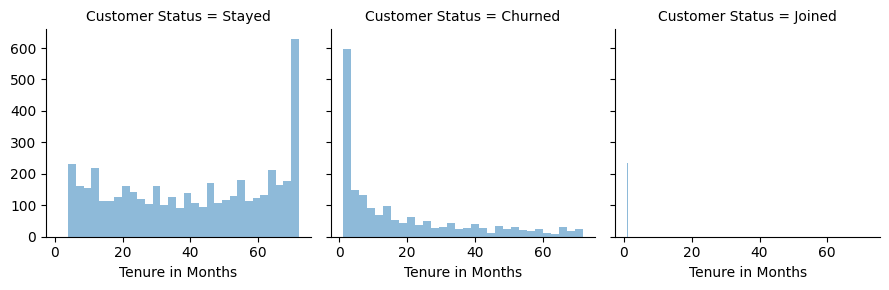

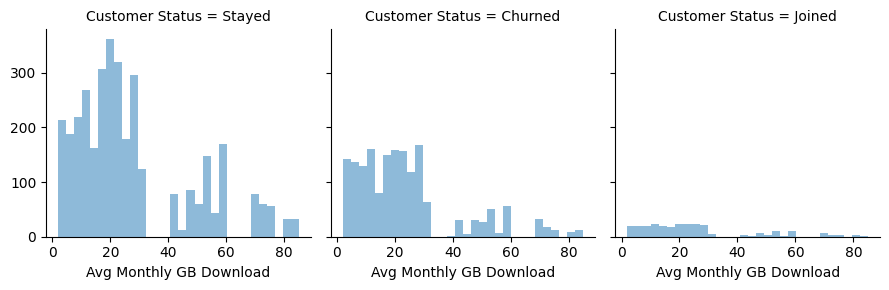

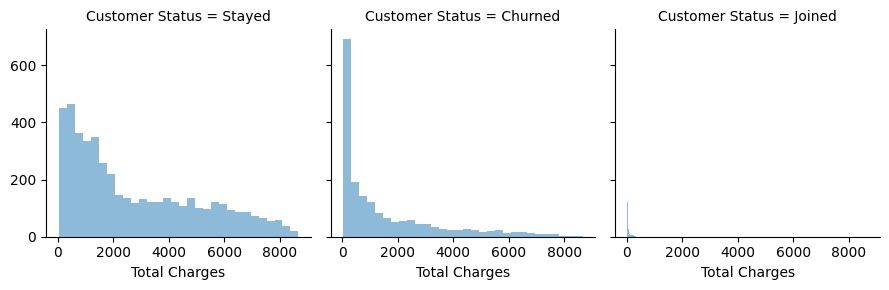

In [18]:
# Visualization
column_name = ['Age', 'Tenure in Months', 'Avg Monthly GB Download', 'Total Charges']
for column in column_name:
  v = sns.FacetGrid(data, col='Customer Status')
  v.map(plt.hist, column, alpha=0.5, bins=30)
  plt.show

In [19]:
# visualization
'''
column_name = [
    #'Age',
    'Total Charges']
indices_name = ['Gender', 'Married', 'Offer', 'Phone Service', 'Internet Service', 'Contract', 'Payment Method']
for column in column_name:
    for k in indices_name:
      v = sns.FacetGrid(data, col='Customer Status', row=k, margin_titles=True)
      v.map(plt.hist, column, alpha=0.5, bins=30)
      plt.show
'''

"\ncolumn_name = [\n    #'Age',\n    'Total Charges']\nindices_name = ['Gender', 'Married', 'Offer', 'Phone Service', 'Internet Service', 'Contract', 'Payment Method']\nfor column in column_name:\n    for k in indices_name:\n      v = sns.FacetGrid(data, col='Customer Status', row=k, margin_titles=True)\n      v.map(plt.hist, column, alpha=0.5, bins=30)\n      plt.show\n"

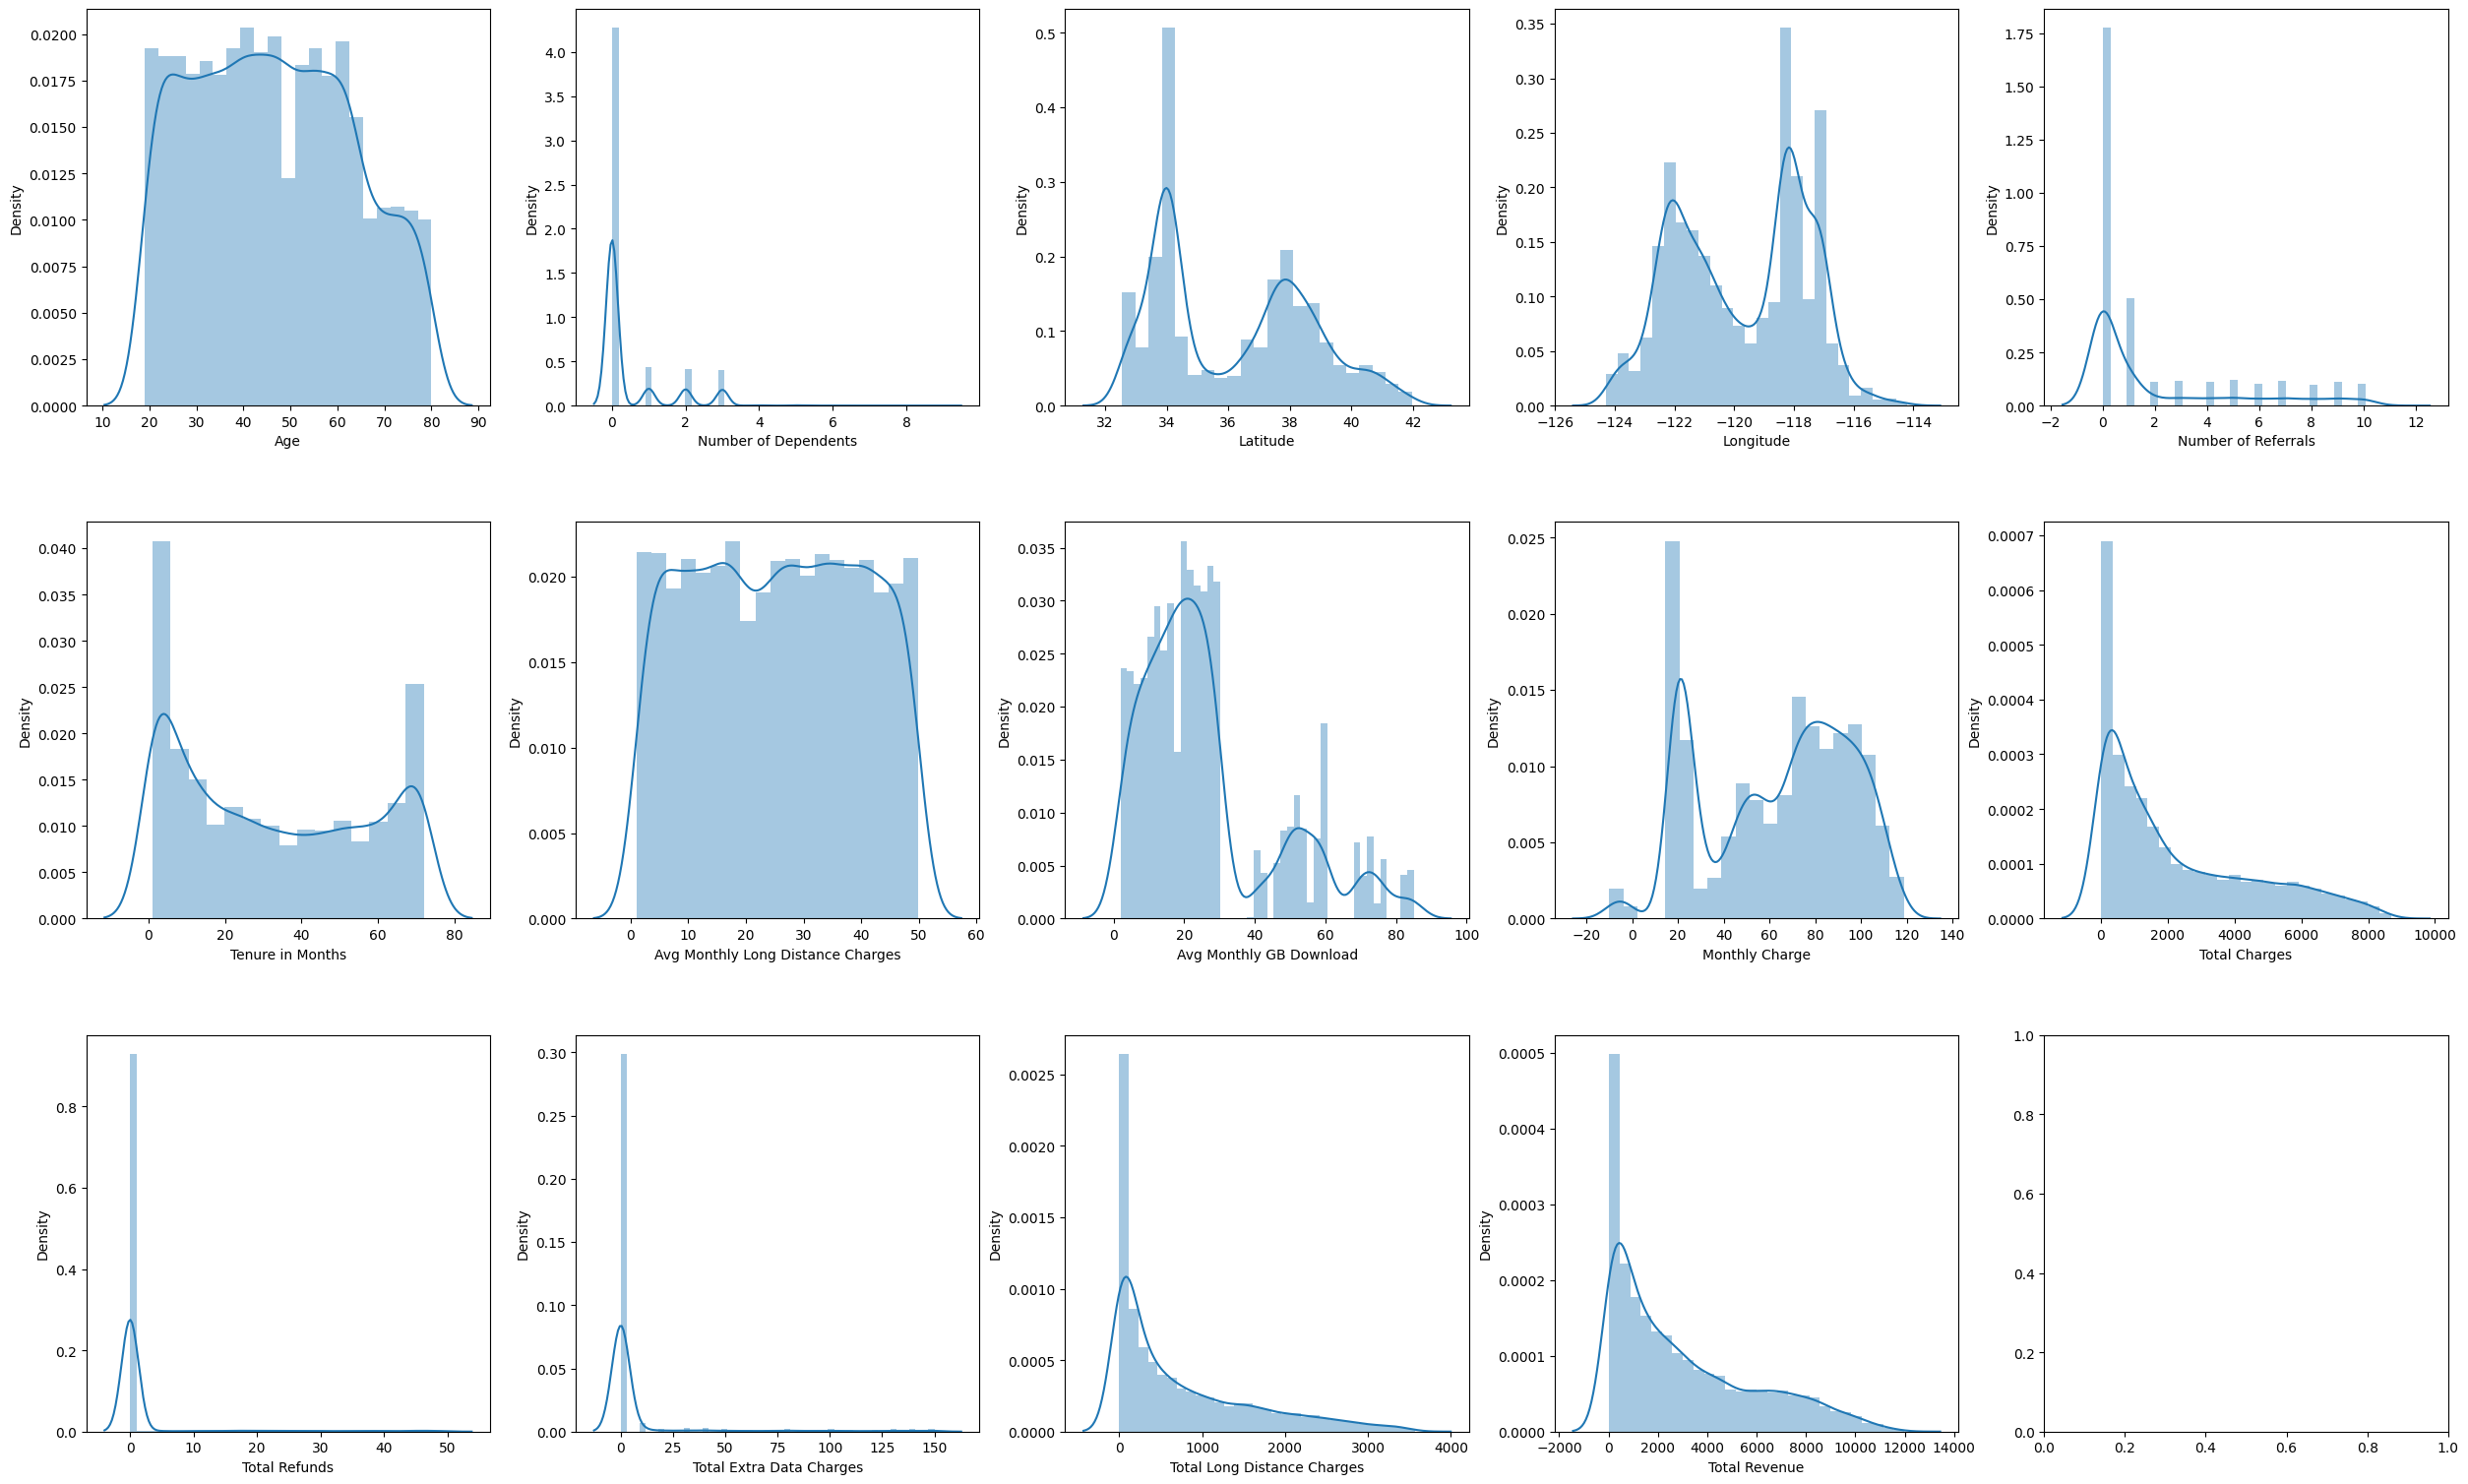

In [20]:
# visualization: distribution plot
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(25,15))
index = 0
axs = axs.flatten()
for k, v in df2.items():
  sns.distplot(v, ax=axs[index])
  index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5)

Age                                      Avg Monthly GB Download
Number of Dependents                     Avg Monthly GB Download
Latitude                                               Longitude
Longitude                                               Latitude
Number of Referrals                             Tenure in Months
Tenure in Months                                   Total Revenue
Avg Monthly Long Distance Charges    Total Long Distance Charges
Avg Monthly GB Download                                      Age
Monthly Charge                                     Total Charges
Total Charges                                      Total Revenue
Total Refunds                                   Tenure in Months
Total Extra Data Charges                           Total Revenue
Total Long Distance Charges                        Total Revenue
Total Revenue                                      Total Charges
dtype: object

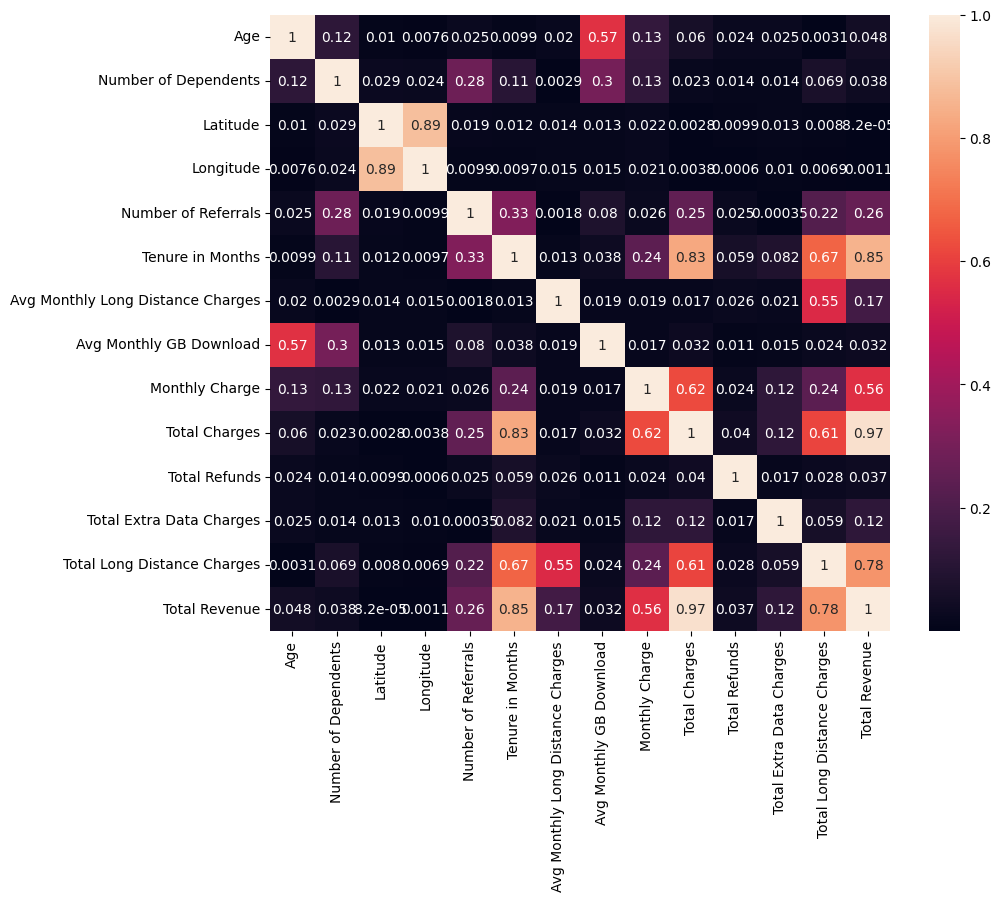

In [21]:
#heat map
corr_mat = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat.abs(), annot=True)

for x in range(len(df2.columns)):
  corr_mat.iloc[x,x] = 0.0
corr_mat.abs().idxmax()

In [22]:
df2 = df2.drop(['Total Revenue'],axis=1)

null values in numerical features:
 Age                                     0
Number of Dependents                    0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Avg Monthly Long Distance Charges     682
Avg Monthly GB Download              1526
Monthly Charge                          0
Total Charges                           0
Total Refunds                           0
Total Extra Data Charges                0
Total Long Distance Charges             0
dtype: int64


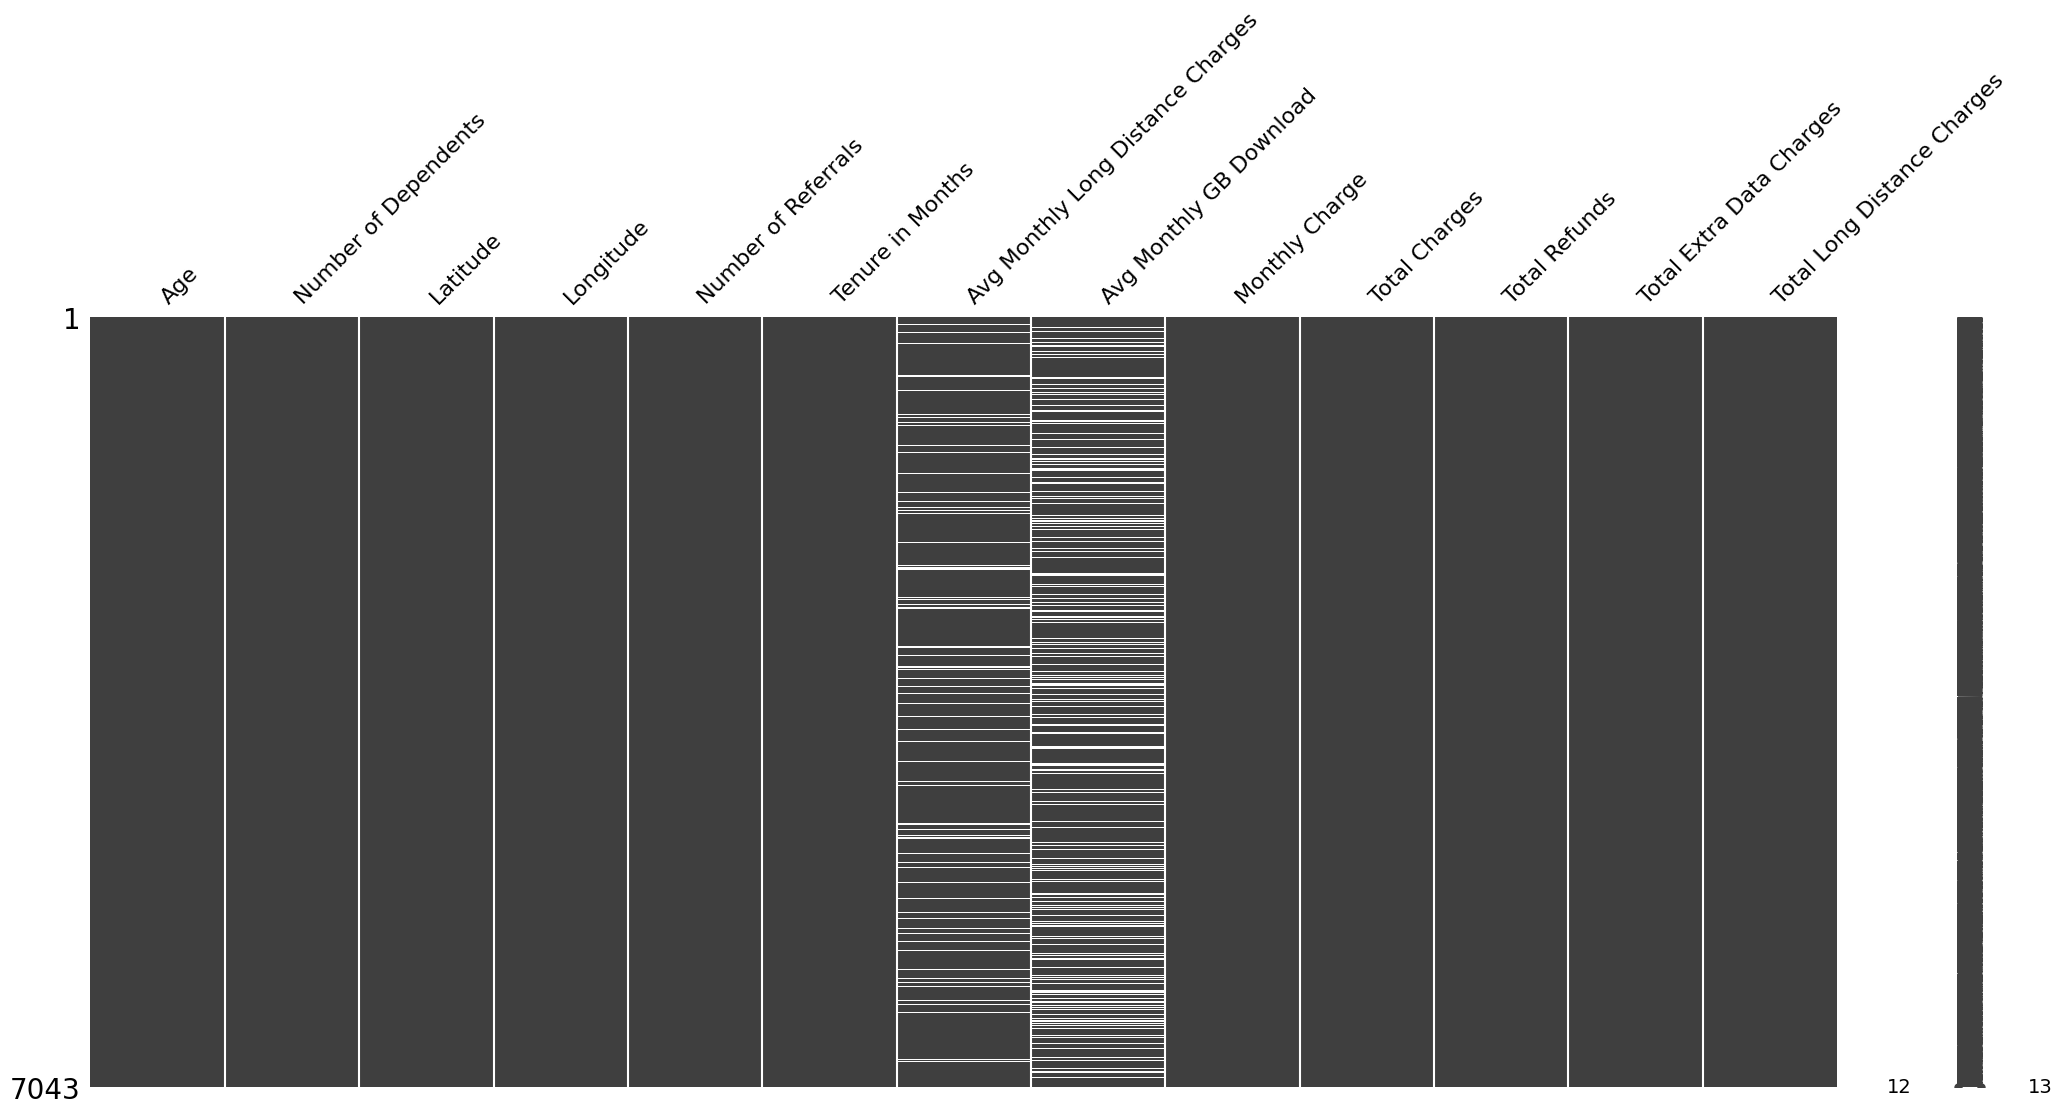

In [23]:
msno.matrix(df2)
print("null values in numerical features:\n",df2.isna().sum())

In [24]:
#filling null values
column_name = ['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download']
for column in column_name:
  df2[column] = df2[column].apply(lambda x: 0 if pd.isnull(x) else x)

null values in numerical features:
 Age                                  0
Number of Dependents                 0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Avg Monthly Long Distance Charges    0
Avg Monthly GB Download              0
Monthly Charge                       0
Total Charges                        0
Total Refunds                        0
Total Extra Data Charges             0
Total Long Distance Charges          0
dtype: int64


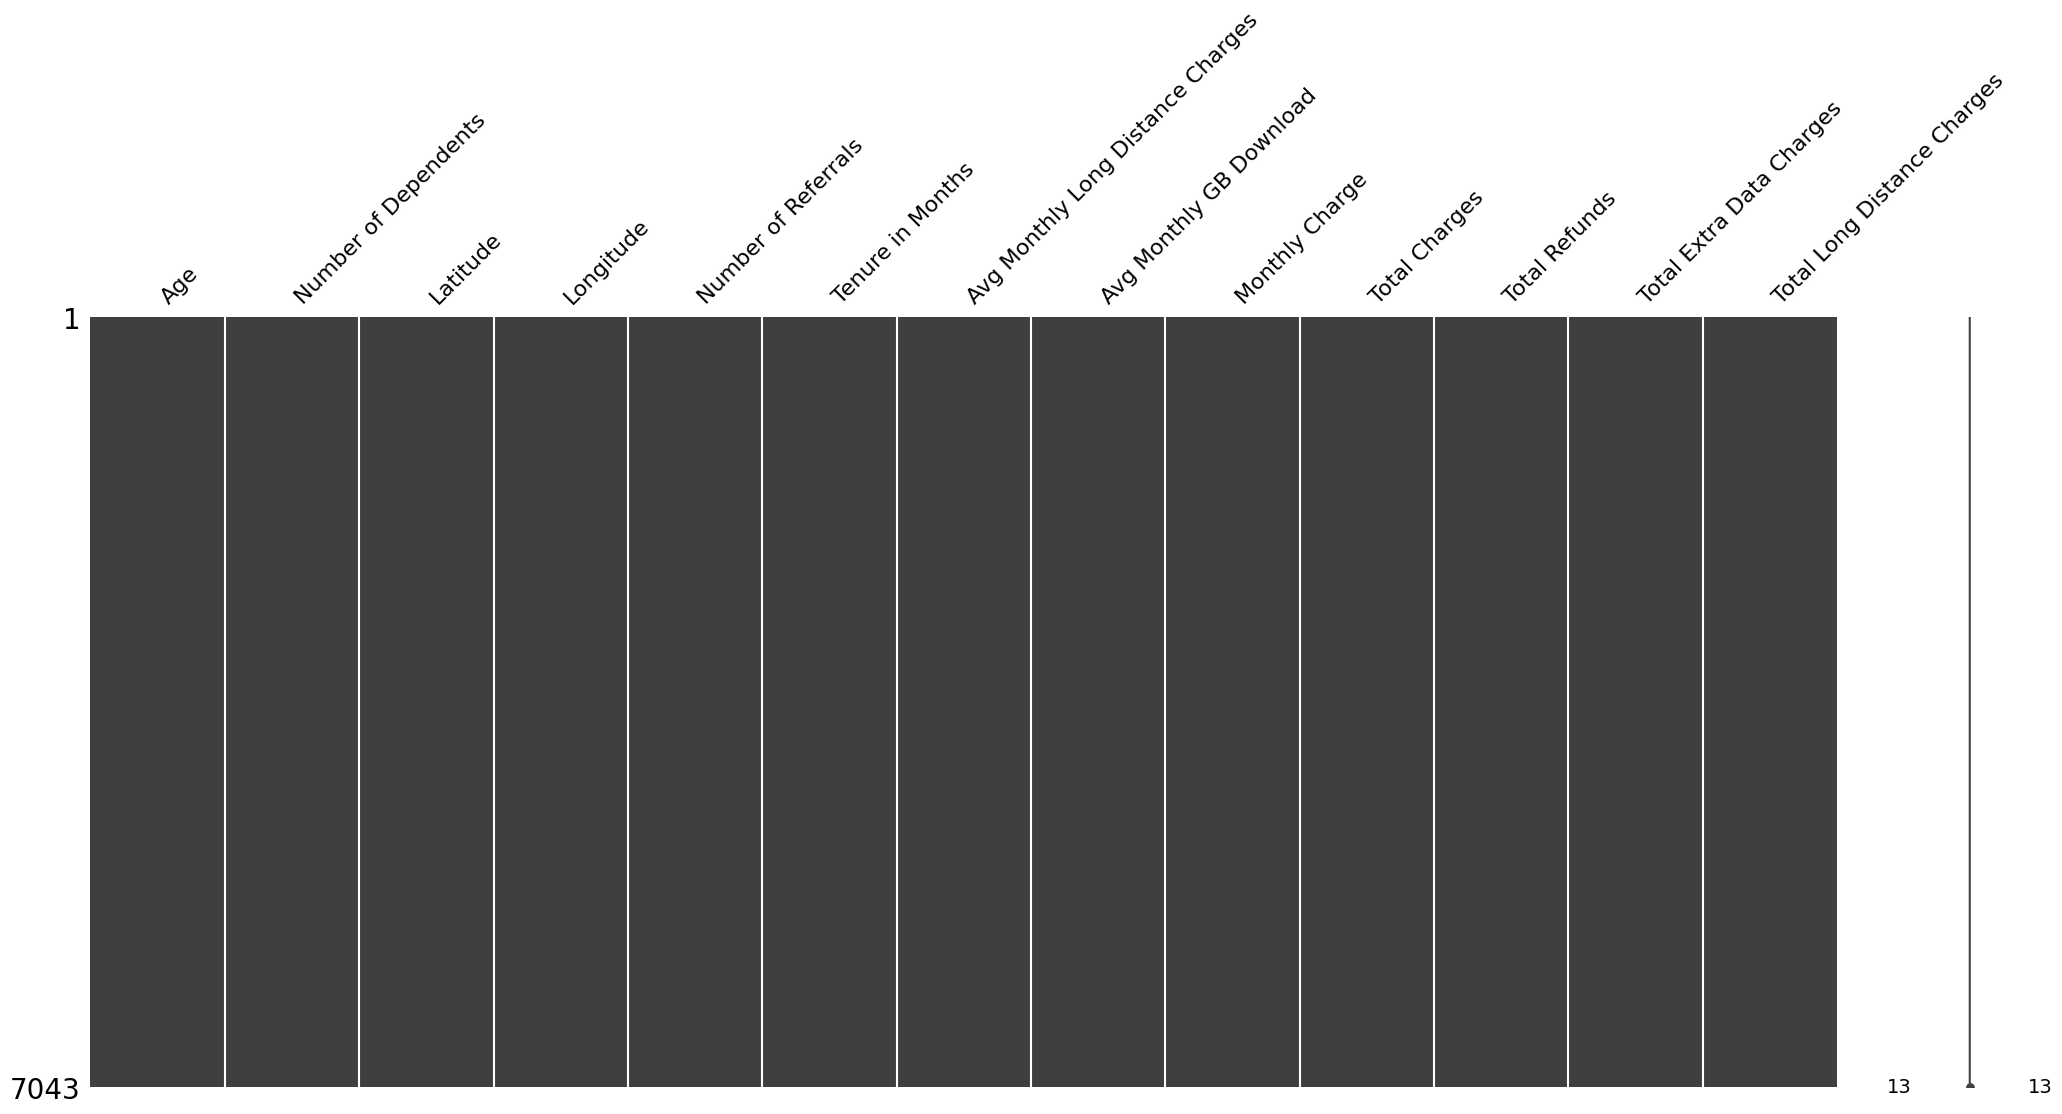

In [25]:
msno.matrix(df2)
print("null values in numerical features:\n",df2.isna().sum())

In [26]:
df = df2.join(df1_imputed)

In [27]:
X = df.drop(['Customer Status'], axis=1)
y = df.loc[:, 'Customer Status'].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
'''
# First method: Isolation Forests
ifor = IsolationForest(max_features=25, n_estimators=100,
                       random_state=np.random.RandomState(42),
                       contamination=0.05, warm_start=True)
y_train_pred = ifor.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask = y_train_pred != -1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]
'''

'\n# First method: Isolation Forests\nifor = IsolationForest(max_features=25, n_estimators=100,\n                       random_state=np.random.RandomState(42),\n                       contamination=0.05, warm_start=True)\ny_train_pred = ifor.fit_predict(X_train_scaled)\n\n# removing outliers(select only the normal data)\nmask = y_train_pred != -1\nX_train_scaled, y_train = X_train_scaled[mask], y_train[mask]\n'

In [31]:
'''
# Second method: Local Outlier Factor
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_train_pred = LOF.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]
'''

'\n# Second method: Local Outlier Factor\nLOF = LocalOutlierFactor(n_neighbors=20, contamination=0.05)\ny_train_pred = LOF.fit_predict(X_train_scaled)\n\n# removing outliers(select only the normal data)\nmask =y_train_pred !=-1\nX_train_scaled, y_train = X_train_scaled[mask], y_train[mask]\n'

In [32]:
'''
# third method: Elliptic
EE = EllipticEnvelope(contamination=0.05, random_state=42)
y_train_pred = EE.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]
'''

'\n# third method: Elliptic\nEE = EllipticEnvelope(contamination=0.05, random_state=42)\ny_train_pred = EE.fit_predict(X_train_scaled)\n\n# removing outliers(select only the normal data)\nmask =y_train_pred !=-1\nX_train_scaled, y_train = X_train_scaled[mask], y_train[mask]\n'

In [33]:
# fourth method: One Class Support Vector Machine
ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
y_train_pred = ocsvm.fit_predict(X_train_scaled)

# removing outliers(select only the normal data)
mask =y_train_pred !=-1
X_train_scaled, y_train = X_train_scaled[mask], y_train[mask]

In [34]:
# GridSearch to determine the best hyperparameter in the SVM model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

svc = SVC()

# Instantiate the grid search model
grid_search_SVC = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_SVC.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search_SVC.best_params_
best_score = grid_search_SVC.best_score_
print(f"Best parameters in SVC: {best_params}")
print(f"Best cross-validation score in SVC: {best_score}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters in SVC: {'C': 100, 'kernel': 'linear'}
Best cross-validation score in SVC: 0.8282833987568082


In [35]:
# using best estimator to make predictions on the test set
best_model_SVC = grid_search_SVC.best_estimator_

In [36]:
# training ohase for best hyperparameter
start_tra = perf_counter()
best_model_SVC.fit(X_train_scaled, y_train)
end_tra = perf_counter()

In [37]:
# print classification report and confusion matrix
y_pred = best_model_SVC.predict(X_test_scaled)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))


def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        265   19   89
1.0         38   59    0
2.0         99    0  840
accuracy = 0.826 
precision = 0.829 
recall = 0.826 
f1 = 0.827


In [38]:
# Accuracy on Train
train_score_SVC = round(best_model_SVC.score(X_train_scaled, y_train), 2)
print("The Training Accuracy is: ", train_score_SVC)

# Accuracy on Test
test_score_SVC = round(best_model_SVC.score(X_test_scaled, y_test), 2)
print("The Testing Accuracy is: ", test_score_SVC)

#training time
train_time_SVC = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_SVC)

The Training Accuracy is:  0.84
The Testing Accuracy is:  0.83
train phase time:  46.2422


In [39]:
# GridSearch to determine the best hyperparameter in the RF model
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
}


rfc = RandomForestClassifier(random_state=42)
grid_search_RF = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')


# Fit the grid search to the data
grid_search_RF.fit(X_train_scaled, y_train)
# Get the best parameters and the best score
best_params = grid_search_RF.best_params_
best_score = grid_search_RF.best_score_

print(f"Best parameters in RF: {best_params}")
print(f"Best cross-validation score in RF: {best_score}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters in RF: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score in RF: 0.8367003367003366


In [40]:
best_model_RF = grid_search_RF.best_estimator_

In [41]:
start_tra = perf_counter()
best_model_RF.fit(X_train_scaled, y_train)
end_tra = perf_counter()

In [42]:
# print classification report and confusion matrix
y_pred = best_model_RF.predict(X_test_scaled)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        229   22  122
1.0         37   59    1
2.0         45    0  894
accuracy = 0.839 
precision = 0.831 
recall = 0.839 
f1 = 0.832


In [43]:
# Accuracy on Train
train_score_RF = round(best_model_RF.score(X_train_scaled, y_train), 2)
print("The Training Accuracy is: ", train_score_RF)

# Accuracy on Test
test_score_RF = round(best_model_RF.score(X_test_scaled, y_test), 2)
print("The Testing Accuracy is: ", test_score_RF)

#training time
train_time_RF = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_RF)

The Training Accuracy is:  0.97
The Testing Accuracy is:  0.84
train phase time:  0.7417


In [44]:
# PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35'),
  Text(40.0, 0, '40')])

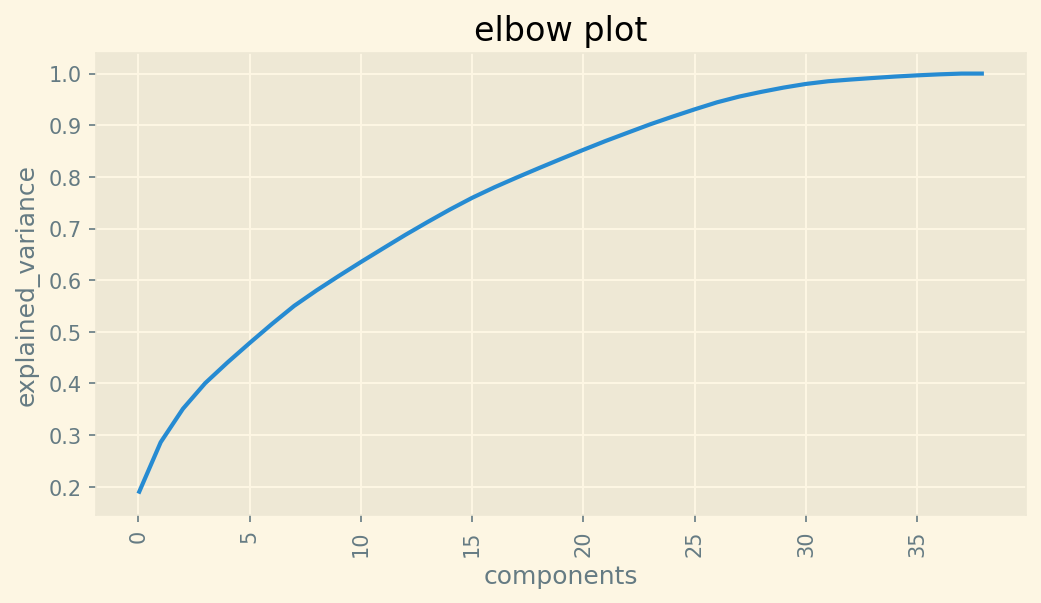

In [45]:
# Determining best n_component for PCA
PC_list = ['PC'+str(i+1) for i in range(39)]

#plotting setup
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 150
plt.style.use('Solarize_Light2')

plt.plot(np.cumsum(pca.explained_variance_ratio_ ))
plt.title('elbow plot')
plt.xlabel('components')
plt.ylabel('explained_variance')
plt.xticks(rotation=90)

In [46]:
total_var = np.cumsum(pca.explained_variance_ratio_*100)

for i in range(38):
  print('PC{:2d}, explained_variance: {:0.2f}'.format(i+1, total_var[i]))

PC 1, explained_variance: 18.67
PC 2, explained_variance: 28.61
PC 3, explained_variance: 35.09
PC 4, explained_variance: 40.05
PC 5, explained_variance: 44.05
PC 6, explained_variance: 47.83
PC 7, explained_variance: 51.51
PC 8, explained_variance: 55.02
PC 9, explained_variance: 58.00
PC10, explained_variance: 60.80
PC11, explained_variance: 63.51
PC12, explained_variance: 66.16
PC13, explained_variance: 68.77
PC14, explained_variance: 71.27
PC15, explained_variance: 73.68
PC16, explained_variance: 75.94
PC17, explained_variance: 77.98
PC18, explained_variance: 79.87
PC19, explained_variance: 81.70
PC20, explained_variance: 83.49
PC21, explained_variance: 85.24
PC22, explained_variance: 86.95
PC23, explained_variance: 88.57
PC24, explained_variance: 90.18
PC25, explained_variance: 91.65
PC26, explained_variance: 93.08
PC27, explained_variance: 94.43
PC28, explained_variance: 95.55
PC29, explained_variance: 96.46
PC30, explained_variance: 97.29
PC31, explained_variance: 97.99
PC32, ex

In [47]:
# PCA by n_components=28
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [48]:
# GridSearch to determine the best hyperparameter in the SVM model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

svc = SVC()

# Instantiate the grid search model
grid_search_SVC_PCA = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_SVC_PCA.fit(X_train_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search_SVC_PCA.best_params_
best_score = grid_search_SVC_PCA.best_score_

print(f"Best parameters in SVC: {best_params}")
print(f"Best cross-validation score in SVC: {best_score}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters in SVC: {'C': 1, 'kernel': 'rbf'}
Best cross-validation score in SVC: 0.7852569000638207


In [49]:
best_model_SVC_PCA = grid_search_SVC_PCA.best_estimator_

In [50]:
# training ohase for best hyperparameter
start_tra = perf_counter()
best_model_SVC_PCA.fit(X_train_pca, y_train)
end_tra = perf_counter()

In [51]:
# print classification report and confusion matrix
y_pred = best_model_SVC_PCA.predict(X_test_pca)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        248   11  114
1.0         47   27   23
2.0         75   16  848
accuracy = 0.797 
precision = 0.786 
recall = 0.797 
f1 = 0.789


In [52]:
# Accuracy on Train
train_score_SVC_PCA = round(best_model_SVC_PCA.score(X_train_pca, y_train), 2)
print("The Training Accuracy is: ", train_score_SVC_PCA)

# Accuracy on Test
test_score_SVC_PCA = round(best_model_SVC_PCA.score(X_test_pca, y_test), 2)
print("The Testing Accuracy is: ", test_score_SVC_PCA)

#training time
train_time_SVC_PCA = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_SVC_PCA)

The Training Accuracy is:  0.82
The Testing Accuracy is:  0.8
train phase time:  1.5666


In [54]:
# GridSearch to determine the best hyperparameter in the RF model
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rfc = RandomForestClassifier(random_state=42)
grid_search_RF_PCA = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_RF_PCA.fit(X_train_pca, y_train)

# Get the best parameters and the best score
best_params = grid_search_RF_PCA.best_params_
best_score = grid_search_RF_PCA.best_score_

print(f"Best parameters in RF: {best_params}")
print(f"Best cross-validation score in RF: {best_score}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters in RF: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score in RF: 0.7833894500561168


In [55]:
best_model_RF_PCA = grid_search_RF_PCA.best_estimator_

In [56]:
start_tra = perf_counter()
best_model_RF_PCA.fit(X_train_pca, y_train)
end_tra = perf_counter()

In [57]:
# print classification report and confusion matrix
y_pred = best_model_RF_PCA.predict(X_test_pca)

print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0.0  1.0  2.0
Actual                  
0.0        227   16  130
1.0         41   22   34
2.0         68   12  859
accuracy = 0.786 
precision = 0.769 
recall = 0.786 
f1 = 0.774


In [58]:
# Accuracy on Train
train_score_RF_PCA = round(best_model_RF_PCA.score(X_train_pca, y_train), 2)
print("The Training Accuracy is: ", train_score_RF_PCA)

# Accuracy on Test
test_score_RF_PCA = round(best_model_RF_PCA.score(X_test_pca, y_test), 2)
print("The Testing Accuracy is: ", test_score_RF_PCA)

#training time
train_time_RF_PCA = round((end_tra-start_tra), 4)
print(f'train phase time: ', train_time_RF_PCA)

The Training Accuracy is:  0.99
The Testing Accuracy is:  0.79
train phase time:  3.3599


In [59]:
Conclusion = pd.DataFrame({'Models':['SVM', 'RF', 'SVM + PCA', 'RF + PCA'],
                          'train acc'               :[train_score_SVC,train_score_RF, train_score_SVC_PCA, train_score_RF_PCA],
                          'test acc'                :[test_score_SVC, test_score_RF,  test_score_SVC_PCA,  test_score_RF_PCA],
                          'training time'           :[train_time_SVC, train_time_RF,  train_time_SVC_PCA,  train_time_RF_PCA]})

Conclusion

,Models,train acc,test acc,training time
0,SVM,0.84,0.83,46.2422
1,RF,0.97,0.84,0.7417
2,SVM + PCA,0.82,0.80,1.5666
3,RF + PCA,0.99,0.79,3.3599
